# 0.分析準備

## 0.1 環境建置

In [10]:
# venv: [IanLi-Data-Analytics-Projects]
# conda activate IanLi-Data-Analytics-Projects
# 指令-安裝所需套件: python -m pip install -r requirements.txt

In [11]:
# 導入所需套件
import pandas as pd                 # 數據處理和分析
import numpy as np                  # 數值運算
import matplotlib.pyplot as plt     # 基礎繪圖
import seaborn as sns               # 進階繪圖，基於 matplotlib
from scipy import stats             # 用於統計檢定
import warnings                     # 用於處理警告訊息
from tabulate import tabulate
import re # 導入正規表達式庫

In [12]:
# 忽略警告訊息，讓 Notebook 輸出更簡潔
warnings.filterwarnings('ignore')

# 設定 Matplotlib 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei'] # 替換為自選中文字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

## 0.2 分析資料

In [13]:
# 定義數據檔案路徑
data_path = '../data/train.csv' # data path

# 載入資料集
try:
    df = pd.read_csv(data_path)
    print("資料載入成功！")
    print("data source: https://www.kaggle.com/competitions/titanic/data?select=test.csv")
    print(f"資料集包含 {df.shape[0]} 行和 {df.shape[1]} 列。")
except FileNotFoundError:
    print(f"錯誤：找不到數據檔案。請確認 '{data_path}' 路徑正確。")
    print("請將 'train.csv' 放到 projects/EDA_Titanic_Survival_Analysis/data/ 資料夾中。")

資料載入成功！
data source: https://www.kaggle.com/competitions/titanic/data?select=test.csv
資料集包含 891 行和 12 列。


### 0.2.2 資料基本型態與特性

In [14]:
# 建立一個 DataFrame 來儲存變數的說明 (中文變數名稱、英文變數名稱、定義、鍵值)
variable_definitions = {
    'Variable': ['survival', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked'],
    '變數說明': ['生還', '艙位等級', '性別', '年齡', '兄弟姊妹/配偶數', '父母/子女數', '船票號碼', '票價', '客艙號碼', '登船港口'],
    'Definition': ['Survival', 'Ticket class', 'Sex', 'Age in years', '# of siblings / spouses aboard the Titanic', '# of parents / children aboard the Titanic', 'Ticket number', 'Passenger fare', 'Cabin number', 'Port of Embarkation'],
    'Key': ['0 = No, 1 = Yes', '1 = 1st, 2 = 2nd, 3 = 3rd', '', '', '', '', '', '', '', 'C = Cherbourg, Q = Queenstown, S = Southampton']
}

# 創建 DataFrame
variables_df = pd.DataFrame(variable_definitions)

# 輸出表格
print("--- 變數說明表 ---")
print(tabulate(variables_df, headers='keys', tablefmt='pretty', showindex=False))
print("------------ 變數說明表 ------------\n")

# 前5行數據
print("資料集前5行：")
print(df.head())
print("------------ 資料集前5行 ------------\n")

# 資料集的基本資訊 (欄位、非空值數量、數據類型)
print("\n資料集的基本資訊：")
df.info()
print("------------ 資料集的基本資訊 ------------\n")

# 資料集的敘述性統計 (僅針對數值型變數欄位)
print("資料集描述性統計(僅針對數值型變數欄位)：")
print(tabulate(df.describe(), headers='keys', tablefmt='pretty', showindex=False))
print("\n資料集的欄位名稱：")
print(df.columns.tolist())
# print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))



--- 變數說明表 ---
+----------+-----------------+--------------------------------------------+------------------------------------------------+
| Variable |    變數說明     |                 Definition                 |                      Key                       |
+----------+-----------------+--------------------------------------------+------------------------------------------------+
| survival |      生還       |                  Survival                  |                0 = No, 1 = Yes                 |
|  pclass  |    艙位等級     |                Ticket class                |           1 = 1st, 2 = 2nd, 3 = 3rd            |
|   sex    |      性別       |                    Sex                     |                                                |
|   age    |      年齡       |                Age in years                |                                                |
|  sibsp   | 兄弟姊妹/配偶數 | # of siblings / spouses aboard the Titanic |                                                |
|  parc

# 1.資料清洗與前處理

## 1.1 缺失值處裡

In [15]:
print("--- 檢查缺失值 ---")
print(df.isnull().sum()) # 顯示每個欄位的缺失值數量
print("\n缺失值比例 (%):")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False)) # 顯示缺失值比例，並按缺失數量降序排列

--- 檢查缺失值 ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

缺失值比例 (%):
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
Sex             0.000000
Parch           0.000000
SibSp           0.000000
Fare            0.000000
Ticket          0.000000
dtype: float64


In [16]:
print("\n--- 處理 Cabin 欄位（缺失率過高，新增一布林值變數代表[有無客艙號資料]以取代該欄位） ---")

# --- 步驟 1: 檢查 Cabin 欄位是否存在，並基於它創建 Has_Cabin ---
if 'Cabin' in df.columns:
    # 創建一個新的特徵 'Has_Cabin'：1 = 有客艙號，0 = 沒有客艙號
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    print("已創建 'Has_Cabin' 欄位")
    # 在丟棄原始欄位之前，先展示原始 Cabin 和新創建的 Has_Cabin 的對比，確認轉換是否正確
    print("原始欄位[Cabin]與新欄位[Has_Cabin]對比（前5行）：")
    print(tabulate(df[['Cabin', 'Has_Cabin']].head(), headers='keys', tablefmt='pretty'))
    # 丟棄原始的 Cabin 欄位
    df = df.drop('Cabin', axis=1)
    print("已創建 'Has_Cabin' 欄位並丟棄原始 'Cabin' 欄位。")
else:
    # 如果 Cabin 欄位已經不存在，但 Has_Cabin 可能還沒創建（例如首次運行或清除輸出後）
    # 檢查 Has_Cabin 是否存在，如果不存在則報錯或提示
    if 'Has_Cabin' not in df.columns:
        # 這種情況通常表示你可能跳過了創建步驟或重啟了Kernel但沒有重新載入數據
        print("\033[31m!警告：'Cabin' 欄位已不存在，且 'Has_Cabin' 欄位尚未創建。請確保數據已正確載入或重新執行所有上一步驟。!\033[0m")
        
    else:
        print("\033[33m!注意：'Cabin' 欄位已不存在，且 'Has_Cabin' 欄位已存在，無需重複操作。!\033[0m")

# --- 步驟 2: 檢查新欄位 'Has_Cabin' 的狀態 ---
# 無論 Cabin 是否存在，Has_Cabin 應該在第一次執行時被創建或跳過。
# 這裡我們只檢查 Has_Cabin 的狀態，確保它能被訪問。
if 'Has_Cabin' in df.columns:
    print("\n新 'Has_Cabin' 欄位（前5行）：")
    print(tabulate(df[['Has_Cabin']].head(), headers='keys', tablefmt='pretty'))

    print("\n'Has_Cabin' 欄位值分佈：")
    print(df['Has_Cabin'].value_counts())
    print(f"有客艙號資料的乘客比例：{df['Has_Cabin'].value_counts(normalize=True)[1]:.2%}")
else:
    print("\n'Has_Cabin' 欄位不存在，請檢查上述步驟。")



--- 處理 Cabin 欄位（缺失率過高，新增一布林值變數代表[有無客艙號資料]以取代該欄位） ---
已創建 'Has_Cabin' 欄位
原始欄位[Cabin]與新欄位[Has_Cabin]對比（前5行）：
+---+-------+-----------+
|   | Cabin | Has_Cabin |
+---+-------+-----------+
| 0 |  nan  |     0     |
| 1 |  C85  |     1     |
| 2 |  nan  |     0     |
| 3 | C123  |     1     |
| 4 |  nan  |     0     |
+---+-------+-----------+
已創建 'Has_Cabin' 欄位並丟棄原始 'Cabin' 欄位。

新 'Has_Cabin' 欄位（前5行）：
+---+-----------+
|   | Has_Cabin |
+---+-----------+
| 0 |     0     |
| 1 |     1     |
| 2 |     0     |
| 3 |     1     |
| 4 |     0     |
+---+-----------+

'Has_Cabin' 欄位值分佈：
Has_Cabin
0    687
1    204
Name: count, dtype: int64
有客艙號資料的乘客比例：22.90%



--- 處理 Age 欄位 ---
在填充缺失值前，先視覺化 `Age` 在不同 `Pclass` 和 `Sex` 組中的分佈：


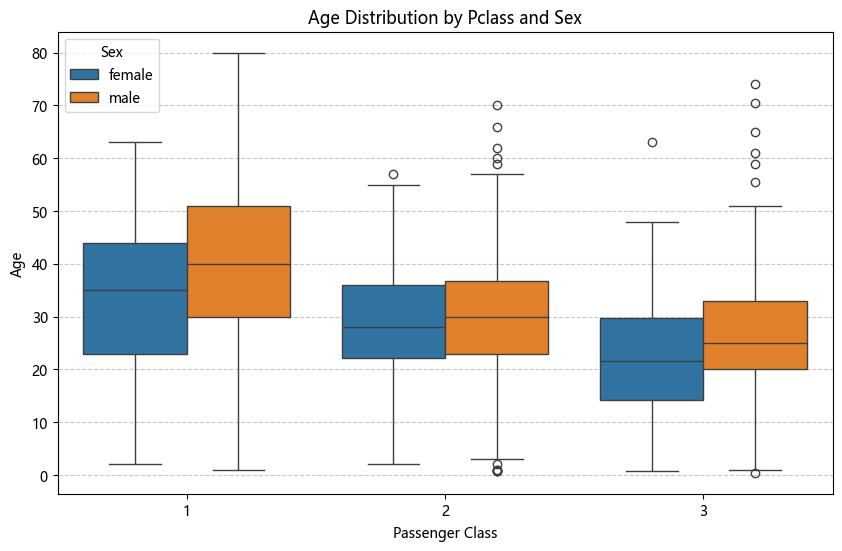

從上圖可見，不同艙位等級和性別的乘客，其年齡分佈確實存在差異。
例如，頭等艙（Pclass=1）的乘客普遍年齡較大，且男性與女性的年齡中位數也略有不同。
這支持我們採用分組中位數填充 `Age` 缺失值的策略。


In [17]:
print("\n--- 處理 Age 欄位 ---")
print("在填充缺失值前，先視覺化 `Age` 在不同 `Pclass` 和 `Sex` 組中的分佈：")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df)
plt.title('Age Distribution by Pclass and Sex')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("從上圖可見，不同艙位等級和性別的乘客，其年齡分佈確實存在差異。")
print("例如，頭等艙（Pclass=1）的乘客普遍年齡較大，且男性與女性的年齡中位數也略有不同。")
print("這支持我們採用分組中位數填充 `Age` 缺失值的策略。")

In [18]:
# 填充 Age 的缺失值：按 Pclass 和 Sex 分組，用中位數填充
# transform 會將填充後的值返回，並保持原始 DataFrame 的索引對齊
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

print("\n`Age` 欄位已按 `Pclass` 和 `Sex` 分組的中位數填充缺失值。")
print(f"再次檢查 `Age` 欄位的缺失值數量：{df['Age'].isnull().sum()}")


`Age` 欄位已按 `Pclass` 和 `Sex` 分組的中位數填充缺失值。
再次檢查 `Age` 欄位的缺失值數量：0


In [19]:
print("\n--- 處理 Embarked 欄位 ---")

# 1. 找出 Embarked 欄位的眾數 (最常見的值)
# .mode() 方法會返回一個 Series，因為可能有多個眾數。我們取第一個。
if 'Embarked' in df.columns:
    if df['Embarked'].isnull().sum() > 0: # 檢查是否確實有缺失值需要填充
        most_common_embarked = df['Embarked'].mode()[0]
        
        # 使用眾數填充缺失值
        df['Embarked'].fillna(most_common_embarked, inplace=True)
        
        print(f"`Embarked` 欄位已用眾數 '{most_common_embarked}' 填充缺失值。")
    else:
        print("`Embarked` 欄位沒有缺失值，無需填充。")
else:
    print("注意：`Embarked` 欄位不存在，請檢查資料集。")


# 2. 再次檢查 Embarked 欄位的缺失值數量，確保填充成功
print(f"再次檢查 `Embarked` 欄位的缺失值數量：{df['Embarked'].isnull().sum()}")

# 3. 檢查 Embarked 欄位的值分佈，確保填充後數據合理
print("\n`Embarked` 欄位值分佈：")
print(df['Embarked'].value_counts())


--- 處理 Embarked 欄位 ---
`Embarked` 欄位已用眾數 'S' 填充缺失值。
再次檢查 `Embarked` 欄位的缺失值數量：0

`Embarked` 欄位值分佈：
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [20]:
print("\n--- 處理後最終檢查所有欄位的缺失值 ---")
final_missing_check = df.isnull().sum()
print(final_missing_check[final_missing_check > 0]) # 只顯示仍有缺失值的欄位

if (final_missing_check == 0).all():
    print("\n恭喜！所有欄位的缺失值都已成功處理。數據已準備好進行更深入的探索性分析！")
else:
    print("\n注意：資料集中仍存在缺失值，請檢查上述處理步驟。")


--- 處理後最終檢查所有欄位的缺失值 ---
Series([], dtype: int64)

恭喜！所有欄位的缺失值都已成功處理。數據已準備好進行更深入的探索性分析！


## 1.2 異常值(Outliers)處裡

### 1.2.1 檢測數值型欄位的異常值
我們主要關注數值型欄位 Age (年齡) 和 Fare (票價)，因為異常值通常發生在這些連續變數上。箱形圖 (Box Plot) 是檢測異常值最直觀且常用的工具。


--- 檢測數值型欄位的異常值 ---


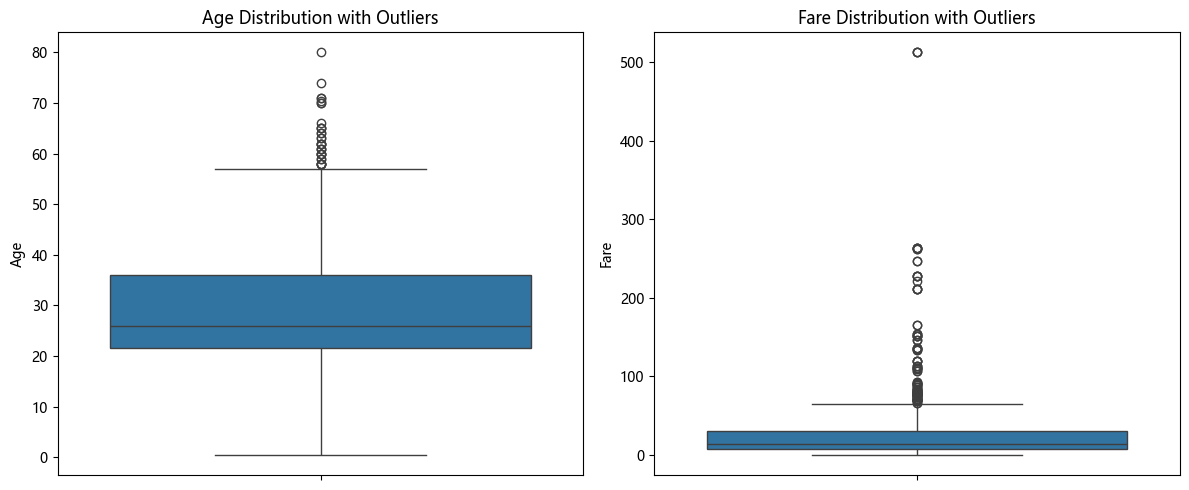

In [21]:
print("\n--- 檢測數值型欄位的異常值 ---")

# 繪製 Age 的箱形圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1行2列的第1個圖
sns.boxplot(y=df['Age'])
plt.title('Age Distribution with Outliers')
plt.ylabel('Age')

# 繪製 Fare 的箱形圖
plt.subplot(1, 2, 2) # 1行2列的第2個圖
sns.boxplot(y=df['Fare'])
plt.title('Fare Distribution with Outliers')
plt.ylabel('Fare')

plt.tight_layout() # 自動調整子圖參數，使之填充整個圖像區域
plt.show()

結果分析與決策：
1. **`Age` (年齡):** 箱形圖顯示 `Age` 欄位存在少數極端值，例如非常年幼的乘客（可能不到1歲）和少數高齡乘客。
- **決策：** 這些年齡雖然是極端值，但它們是**真實的乘客數據**，且對於分析生還率可能具有重要意義（例如嬰幼兒的生還率可能更高）。因此，本專案決定**保留這些年齡異常值**，不進行硬性移除或替換，以避免潛在的資訊損失。
2. **`Fare` (票價):** `Fare` 欄位呈現明顯的右偏分佈，並存在大量極端高的值。這些高票價通常代表頭等艙乘客或購買了豪華套房的乘客，這也是**真實數據**。
- **決策：** 為了減少其在統計分析或機器學習模型中過度影響（例如，少數幾個極高票價可能會扭曲平均值或導致模型對其過度敏感），同時也為了使其分佈更接近常態分佈（這對某些統計方法和模型是有利的），我們決定對其進行**對數轉換 (Log Transformation)**。

### 1.2.2 處理欄位[ Fare ]異常值
利用常用的[對數轉換]技術，壓縮數據的範圍（特別是對於右偏分佈的數據），讓數據分佈更接近常態，減少極端值的影響。

hint: 使用 np.log1p() 函數，它計算 log(1+x)，這樣可以安全地處理原始值為 0 的情況（因為 log(0) 是未定義的）。

--- 處理 `Fare` 欄位異常值 (對數轉換) ---
注意：`Fare` 欄位包含 0 值，將使用 `np.log1p` 進行對數轉換以避免計算錯誤。


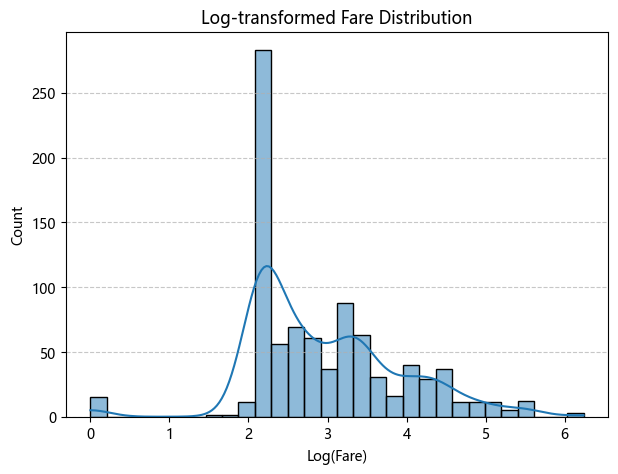

`Fare` 欄位已進行對數轉換，並創建了新的特徵 `Fare_log`。
轉換後的分佈更接近常態分佈，有助於後續的統計分析和機器學習模型。

原始 `Fare` 與 `Fare_log` 欄位對比（前5行）：
      Fare  Fare_log
0   7.2500  2.110213
1  71.2833  4.280593
2   7.9250  2.188856
3  53.1000  3.990834
4   8.0500  2.202765


In [22]:
print("--- 處理 `Fare` 欄位異常值 (對數轉換) ---")

# 對 Fare 欄位進行對數轉換。
# np.log1p(x) 等於 np.log(1+x)，可以安全處理原始值為 0 的情況。
# 檢查是否有票價為0的，如果有，使用 log1p 更穩妥。
if (df['Fare'] == 0).any():
    print("注意：`Fare` 欄位包含 0 值，將使用 `np.log1p` 進行對數轉換以避免計算錯誤。")
    df['Fare_log'] = np.log1p(df['Fare'])
else:
    df['Fare_log'] = np.log(df['Fare']) # 如果沒有0值，也可以直接使用 np.log

# 繪製對數轉換後的 Fare 分佈，查看效果
plt.figure(figsize=(7, 5))
sns.histplot(df['Fare_log'], kde=True, bins=30) # 增加 bin 數量可以看得更細緻
plt.title('Log-transformed Fare Distribution')
plt.xlabel('Log(Fare)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("`Fare` 欄位已進行對數轉換，並創建了新的特徵 `Fare_log`。")
print("轉換後的分佈更接近常態分佈，有助於後續的統計分析和機器學習模型。")
# 顯示原始 Fare 和轉換後的 Fare_log 的前幾行對比
print("\n原始 `Fare` 與 `Fare_log` 欄位對比（前5行）：")
print(df[['Fare', 'Fare_log']].head())

## 1.3 特徵工程 (Feature Engineering)
透過特徵工程從現有特徵中創造出更有價值(更具代表性、可呈現潛在模式及額外重要資訊)的新特徵。
欲增加的新特徵：

1. 創造家庭人數 (FamilySize)：各乘客的家庭人數將可能顯著影響生還率。本特徵為SibSp(兄弟姊妹/配偶數)和Parch(父母/子女數)加總，再加1(自己)所得。

2. 是否獨自旅行 (IsAlone)：獨自旅行的乘客與有家庭成員陪伴的乘客，其行為和生還率可能不同，於此根據 FamilySize 欄位判斷。

3. 提取姓名中的稱謂 (Title)：乘客姓名中的稱謂（如 Mr., Miss., Mrs., Master.）通常隱含了他們的性別、婚姻狀況和年齡等資訊，可能可由該資訊得出其餘特徵無法顯示之隱含資訊，對於生還率可能是一個強大的預測因子。

In [23]:
print("--- 特徵工程：創造家庭人數 (FamilySize) ---")

# FamilySize = SibSp(配偶、兄弟姊妹人數) + Parch(父母、小孩人數) + 1 (包含自己)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
print("已成功創建 `FamilySize` 欄位。")
print(df[['SibSp', 'Parch', 'FamilySize']].head())

--- 特徵工程：創造家庭人數 (FamilySize) ---
已成功創建 `FamilySize` 欄位。
   SibSp  Parch  FamilySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1


In [24]:
print("\n--- 特徵工程：創造是否獨自旅行 (IsAlone) ---")

# IsAlone = 1 (是獨自旅行) if FamilySize == 1, else 0
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
print("已成功創建 `IsAlone` 欄位。")
print(df[['FamilySize', 'IsAlone']].head())


--- 特徵工程：創造是否獨自旅行 (IsAlone) ---
已成功創建 `IsAlone` 欄位。
   FamilySize  IsAlone
0           2        0
1           2        0
2           1        1
3           2        0
4           1        1


In [25]:
import re # 導入正規表達式庫

print("\n--- 特徵工程：從姓名中提取稱謂 (Title) ---")

# 使用正規表達式從 Name 欄位中提取稱謂
# 稱謂通常在名字後方，以逗號和空格開頭，並以點號結尾
df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))

# 處理一些罕見的稱謂，將它們歸類為 'Rare'
uncommon_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['Title'] = df['Title'].replace(uncommon_titles, 'Rare')

# 處理其他較為常見的稱謂變體
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

print("已從 `Name` 欄位中提取並簡化 `Title` 欄位。")
print("\n`Title` 欄位值分佈：")
print(df['Title'].value_counts())


--- 特徵工程：從姓名中提取稱謂 (Title) ---
已從 `Name` 欄位中提取並簡化 `Title` 欄位。

`Title` 欄位值分佈：
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


In [26]:
print("\n--- 資料類型轉換 ---")

# 觀察數據類型
print("\n原始資料類型：")
print(df.info())

# 將 Survived, Pclass, Sex, Embarked, Has_Cabin, IsAlone, Title 轉換為類別型 (Category)
for col in ['Survived', 'Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'IsAlone', 'Title']:
    if col in df.columns:
        df[col] = df[col].astype('category')
        print(f"欄位 '{col}' 已轉換為 'category' 類型。")
    else:
        print(f"警告：欄位 '{col}' 不存在，無法進行轉換。")

# 再次檢查轉換後的數據類型
print("\n轉換後資料類型：")
print(df.info())


--- 資料類型轉換 ---

原始資料類型：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Has_Cabin    891 non-null    int64  
 12  Fare_log     891 non-null    float64
 13  FamilySize   891 non-null    int64  
 14  IsAlone      891 non-null    int64  
 15  Title        891 non-null    object 
dtypes: float64(3), int64(8), object(5)
memory usage: 111.5+ KB
None
欄位 'Survived' 已轉換為 'category' 類型。
欄位 'Pclass'

# 2.探索性分析與視覺化

## 2.1 特徵總覽 [生還率Survived]

### 2.1.1 生還率與類別變數的關係


--- 探索生還率總覽 ---
總生還人數: 342
總乘客數: 891

總生還率：
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


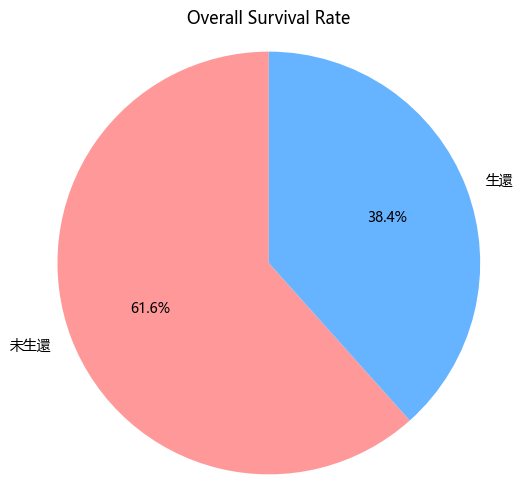

In [27]:
print("\n--- 探索生還率總覽 ---")

# 將 'Survived' 欄位臨時轉換為 int，以進行 sum() 計算
# df['Survived'].astype(int) 是一個臨時的 Series，不會修改原始 df
total_survived = df['Survived'].astype(int).sum()
total_passengers = len(df)

print(f"總生還人數: {total_survived}")
print(f"總乘客數: {total_passengers}")

# 計算生還率，這部分可以保持不變
survival_rate = df['Survived'].value_counts(normalize=True) * 100
print("\n總生還率：")
print(survival_rate)

# 繪製生還率圓餅圖，這裡也可以保持不變
plt.figure(figsize=(6, 6))
plt.pie(survival_rate, labels=['未生還', '生還'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Overall Survival Rate')
plt.axis('equal') # 確保圓餅圖是圓的
plt.show()

### 2.1.2 各項類別變數之生還率

In [28]:
print("\n--- 建立年齡分群變數 ---")

# 定義年齡分組的邊界與標籤
bins = [0, 12, 18, 60, np.inf]
labels = ['Child(11以下)', 'Teen(12-17)', 'Adult(19-58)', 'Senior(59以上)']

# 使用 pd.cut() 函數將 Age 欄位分群
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

print("已成功創建 'Age_Group' 欄位。")
print("\n'Age_Group' 欄位值分佈：")
print(df['Age_Group'].value_counts())


--- 建立年齡分群變數 ---
已成功創建 'Age_Group' 欄位。

'Age_Group' 欄位值分佈：
Age_Group
Adult(19-58)    752
Child(11以下)      68
Teen(12-17)      45
Senior(59以上)     26
Name: count, dtype: int64


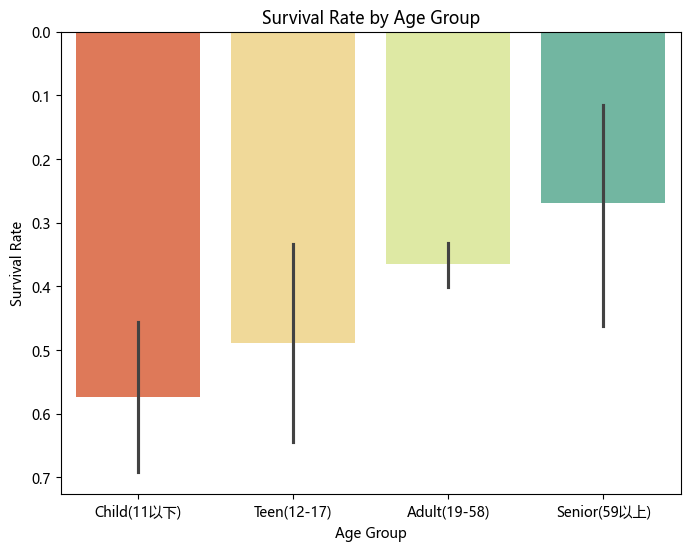


**視覺化洞察：**
1. **兒童 (Child) 的生還率最高**，這再次證實了我們在直方圖中的觀察，並量化了這一發現。
2. **老年人 (Senior) 的生還率似乎也高於成年人 (Adult)**。
3. **青少年 (Teen) 的生還率最低**。
這證明了年齡，尤其是特定的年齡區間，是影響生還與否的一個關鍵因素。


In [29]:
# 繪製 Age_Group 與生還率的長條圖
plt.figure(figsize=(8, 6))
sns.barplot(x='Age_Group', y='Survived', data=df, palette='Spectral')
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

print("\n**視覺化洞察：**")
print("1. **兒童 (Child) 的生還率最高**，這再次證實了我們在直方圖中的觀察，並量化了這一發現。")
print("2. **老年人 (Senior) 的生還率似乎也高於成年人 (Adult)**。")
print("3. **青少年 (Teen) 的生還率最低**。")
print("這證明了年齡，尤其是特定的年齡區間，是影響生還與否的一個關鍵因素。")


--- 生還率與所有類別變數的關係 ---


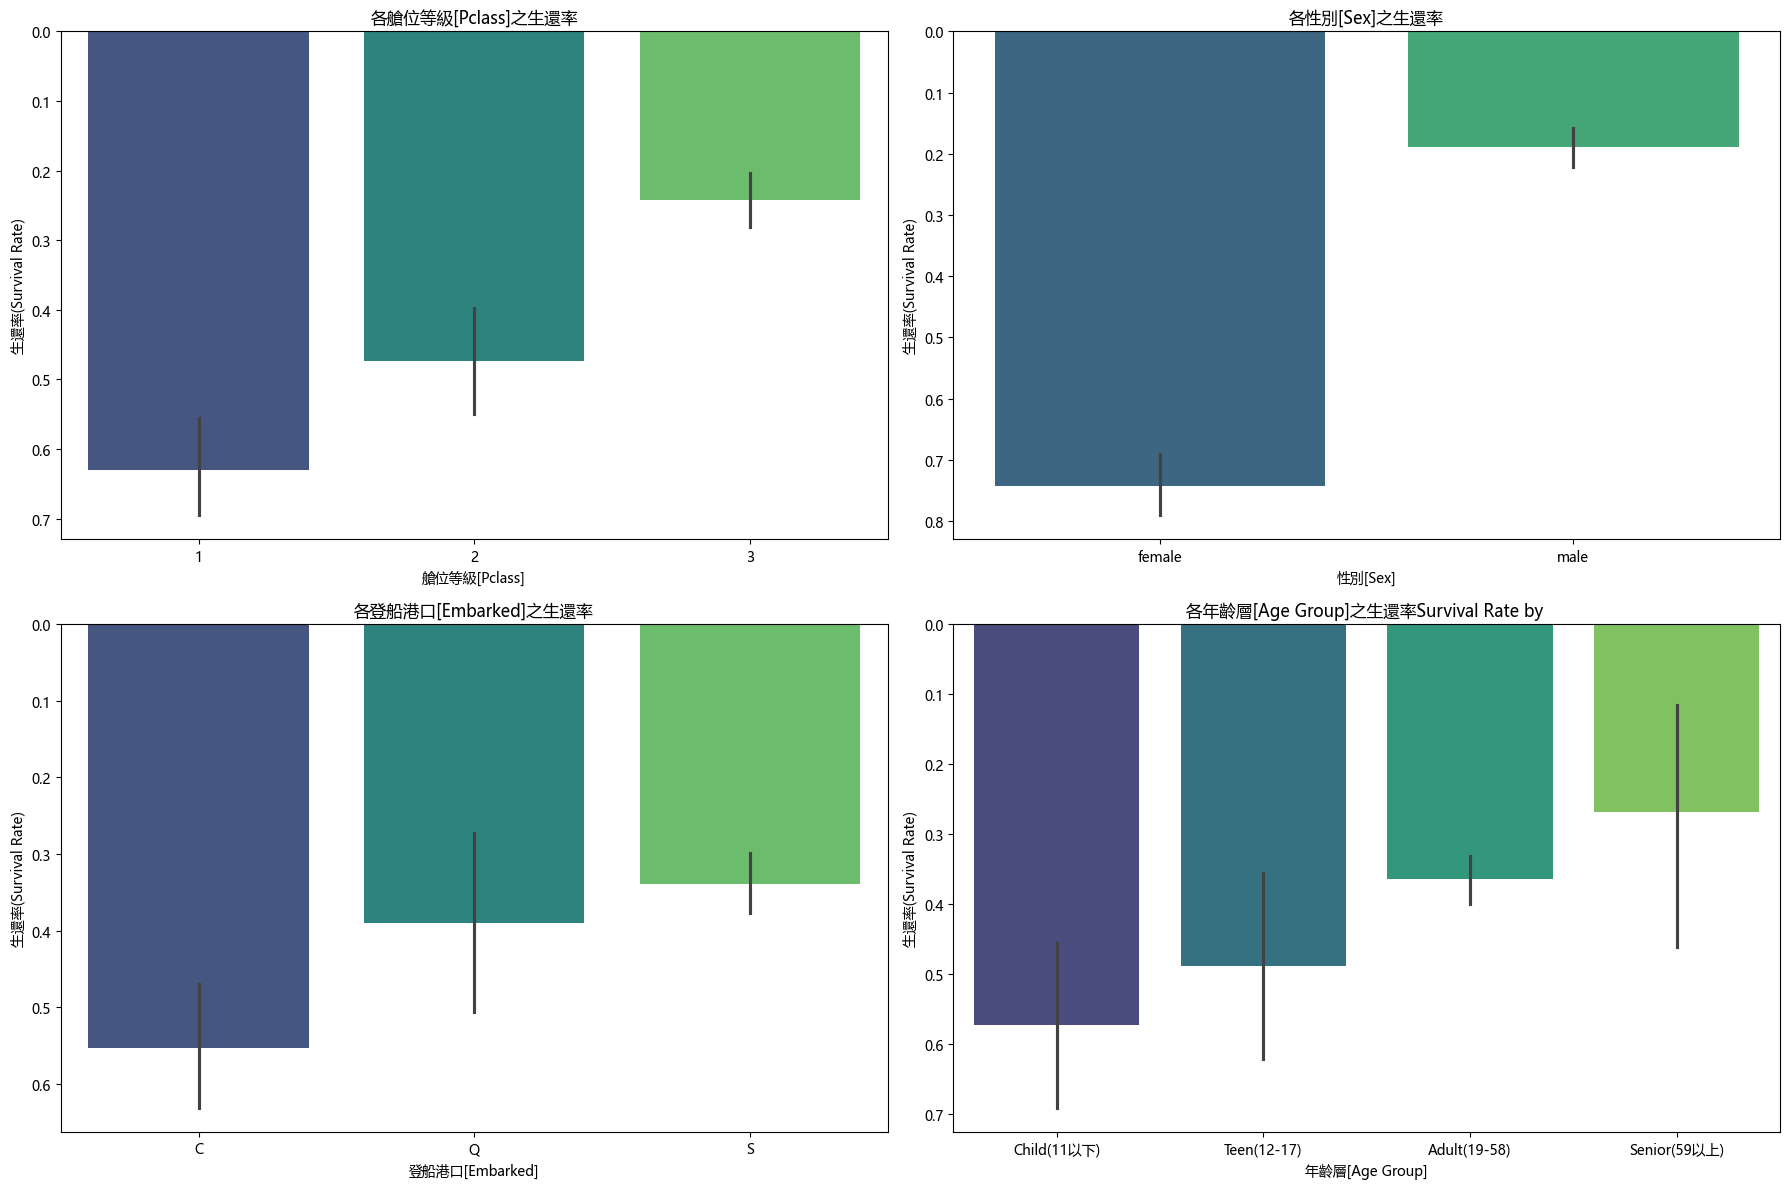


**視覺化洞察：**
1. **艙位等級 (Pclass):** 一等艙乘客的生還率顯著高於二等艙和三等艙。這顯示社會經濟地位是影響生還的重要因素。
2. **性別 (Sex):** 女性乘客的生還率遠高於男性。這強烈印證了「婦女和兒童優先」的救援原則。
3. **登船港口 (Embarked):** C 港（Cherbourg）的乘客生還率似乎略高於其他港口。
4. **年齡分組 (Age Group):** **兒童 (Child)** 的生還率最高，而青少年 (Teen) 和成年人 (Adult) 的生還率相對較低。這再次凸顯了年齡在生還決策中的作用。


In [30]:
print("\n--- 生還率與所有類別變數的關係 ---")

# 設定圖表布局
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 繪製 Pclass 與生還率
sns.barplot(x='Pclass', y='Survived', data=df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('各艙位等級[Pclass]之生還率')
axes[0, 0].set_xlabel('艙位等級[Pclass]')
axes[0, 0].set_ylabel('生還率(Survival Rate)')

# 繪製 Sex 與生還率
sns.barplot(x='Sex', y='Survived', data=df, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('各性別[Sex]之生還率')
axes[0, 1].set_xlabel('性別[Sex]')
axes[0, 1].set_ylabel('生還率(Survival Rate)')

# 繪製 Embarked 與生還率
sns.barplot(x='Embarked', y='Survived', data=df, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('各登船港口[Embarked]之生還率')
axes[1, 0].set_xlabel('登船港口[Embarked]')
axes[1, 0].set_ylabel('生還率(Survival Rate)')

# 繪製 Age_Group 與生還率
sns.barplot(x='Age_Group', y='Survived', data=df, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('各年齡層[Age Group]之生還率Survival Rate by ')
axes[1, 1].set_xlabel('年齡層[Age Group]')
axes[1, 1].set_ylabel('生還率(Survival Rate)')

plt.tight_layout()
plt.show()

print("\n**視覺化洞察：**")
print("1. **艙位等級 (Pclass):** 一等艙乘客的生還率顯著高於二等艙和三等艙。這顯示社會經濟地位是影響生還的重要因素。")
print("2. **性別 (Sex):** 女性乘客的生還率遠高於男性。這強烈印證了「婦女和兒童優先」的救援原則。")
print("3. **登船港口 (Embarked):** C 港（Cherbourg）的乘客生還率似乎略高於其他港口。")
print("4. **年齡分組 (Age Group):** **兒童 (Child)** 的生還率最高，而青少年 (Teen) 和成年人 (Adult) 的生還率相對較低。這再次凸顯了年齡在生還決策中的作用。")


--- 各項類別變數之生還率 ---


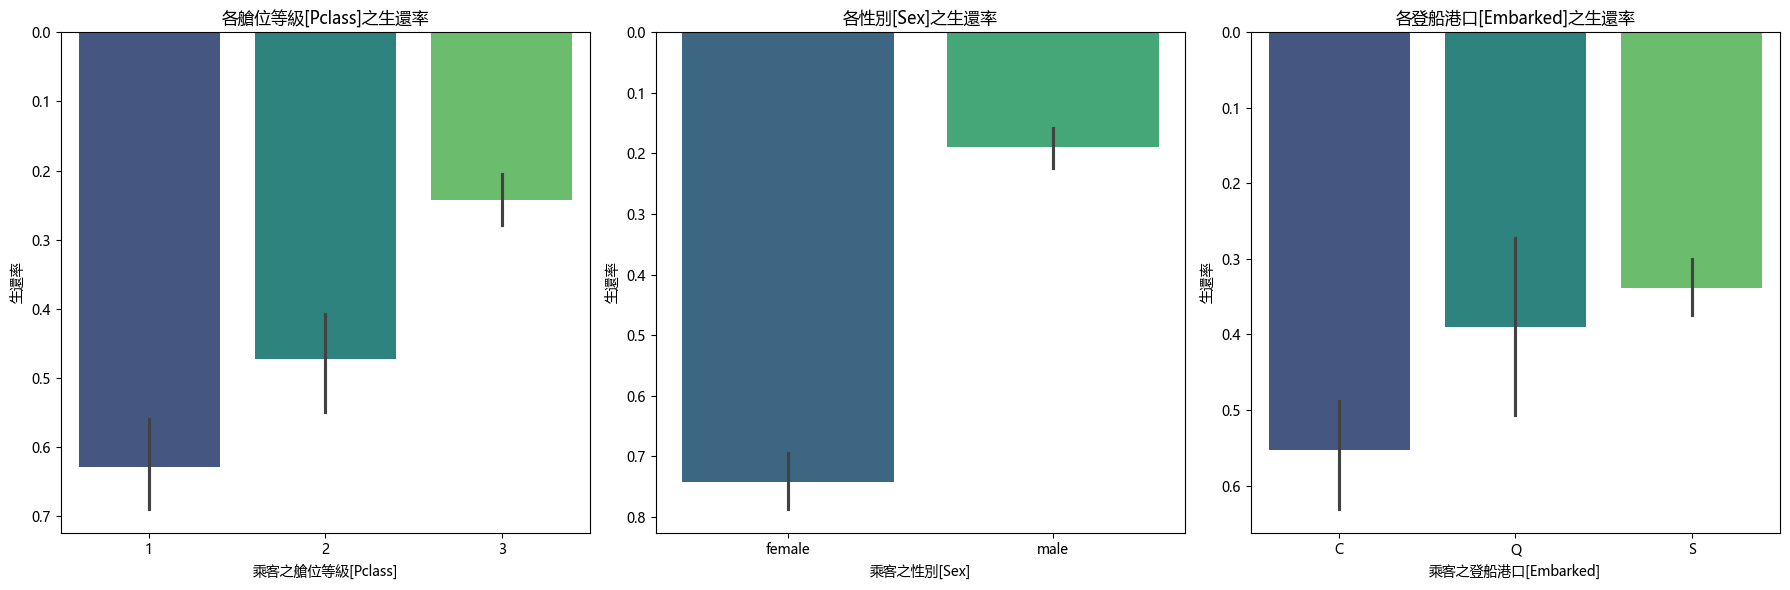


**視覺化圖表結果分析：**
1. **艙位等級 (Pclass):** 一等艙乘客的生還率顯著高於二等艙和三等艙。
2. **性別 (Sex):** 女性乘客的生還率遠高於男性，這印證了逃難時「婦女優先」的原則。
3. **登船港口 (Embarked):** C 港（Cherbourg）的乘客生還率似乎略高於 S 港（Southampton）和 Q 港（Queenstown）。


In [31]:
print("\n--- 各項類別變數之生還率 ---")

# 繪製 艙位等級[Pclass], 性別[Sex], 登船港口[Embarked] 生還率圖
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 各艙位等級[Pclass]之生還率
sns.barplot(x='Pclass', y='Survived', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('各艙位等級[Pclass]之生還率')
axes[0].set_xlabel('乘客之艙位等級[Pclass]')
axes[0].set_ylabel('生還率')

# 各性別[Sex]之生還率
sns.barplot(x='Sex', y='Survived', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('各性別[Sex]之生還率')
axes[1].set_xlabel('乘客之性別[Sex]')
axes[1].set_ylabel('生還率')

# 各登船港口[Embarked]之生還率
sns.barplot(x='Embarked', y='Survived', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('各登船港口[Embarked]之生還率')
axes[2].set_xlabel('乘客之登船港口[Embarked]')
axes[2].set_ylabel('生還率')
"""
# 各年齡層[Age](自行分群處理)之生還率 (自行分群處理)
sns.barplot(x='Embarked', y='Survived', data=df, ax=axes[2], palette='viridis')
axes[3].set_title('各年齡層[Age](自行分群處理)之生還率')
axes[3].set_xlabel('乘客之年齡層[Age](自行分群處理)')
axes[3].set_ylabel('生還率')
"""
plt.tight_layout()
plt.show()

print("\n**視覺化圖表結果分析：**")
print("1. **艙位等級 (Pclass):** 一等艙乘客的生還率顯著高於二等艙和三等艙。")
print("2. **性別 (Sex):** 女性乘客的生還率遠高於男性，這印證了逃難時「婦女優先」的原則。")
print("3. **登船港口 (Embarked):** C 港（Cherbourg）的乘客生還率似乎略高於 S 港（Southampton）和 Q 港（Queenstown）。")

### 2.1.3 生還率與連續變數的關係


--- 生還率與連續變數的關係 ---


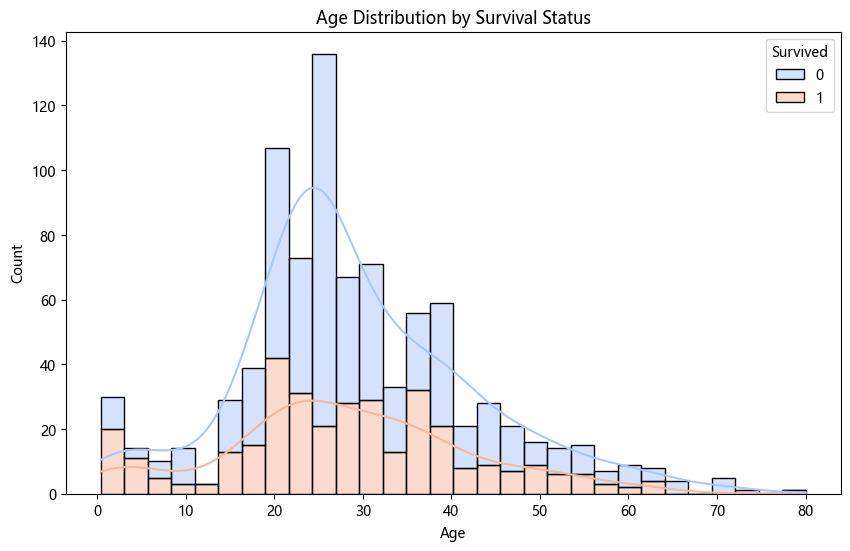

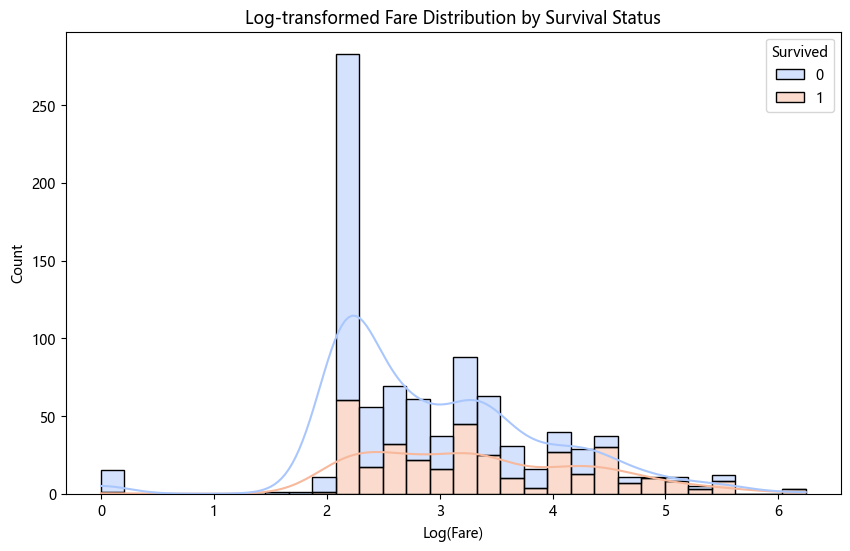


**視覺化洞察：**
1. **年齡 (Age):** 兒童（尤其是10歲以下）的生還比例似乎較高。而青壯年的未生還人數則較多。
2. **票價 (Fare):** 票價較高的乘客生還率似乎更高，這與艙位等級的發現相符（高票價通常意味著高艙位等級）。


In [32]:
print("\n--- 生還率與連續變數的關係 ---")

# 繪製 Age 的分佈，並按生還狀態區分binsnp
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Survived', kde=True, bins=30, multiple='stack', palette='coolwarm')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 繪製 Fare_log 的分佈，並按生還狀態區分
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Fare_log', hue='Survived', kde=True, bins=30, multiple='stack', palette='coolwarm')
plt.title('Log-transformed Fare Distribution by Survival Status')
plt.xlabel('Log(Fare)')
plt.ylabel('Count')
plt.show()

print("\n**視覺化洞察：**")
print("1. **年齡 (Age):** 兒童（尤其是10歲以下）的生還比例似乎較高。而青壯年的未生還人數則較多。")
print("2. **票價 (Fare):** 票價較高的乘客生還率似乎更高，這與艙位等級的發現相符（高票價通常意味著高艙位等級）。")

### 2.3.4 探索新創造特徵的影響


--- 新特徵與生還率的關係 ---


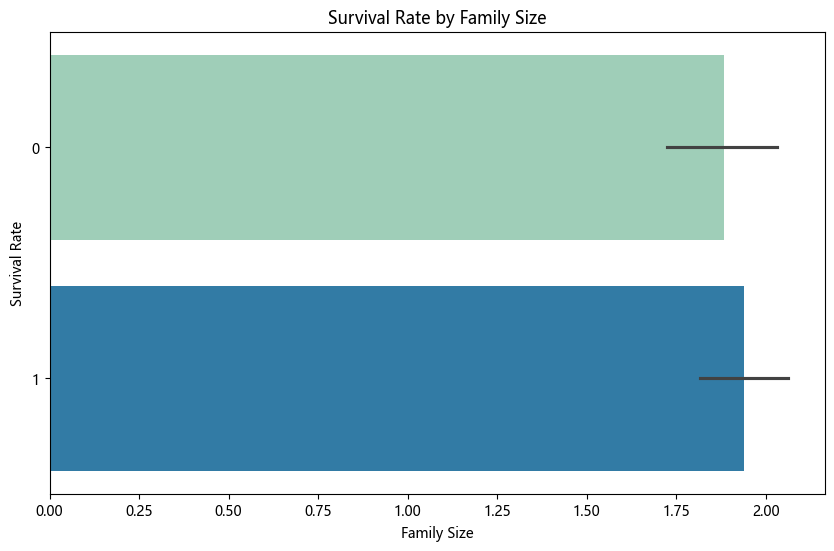

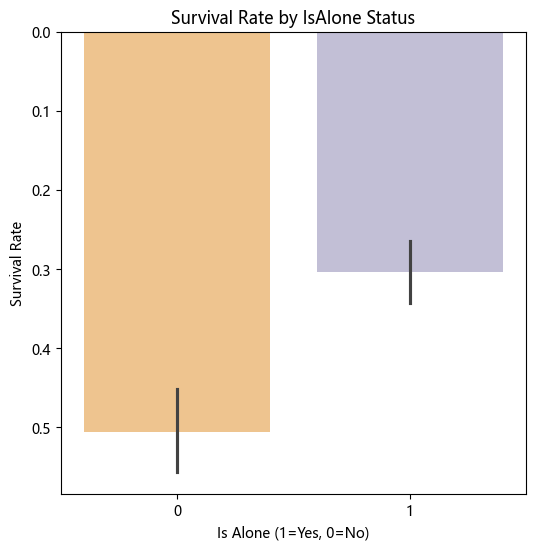


**視覺化洞察：**
1. **家庭人數 (FamilySize):** 家庭人數為 2-4 人的乘客生還率似乎最高，而獨自旅行或家庭人數過大的乘客生還率相對較低。
2. **是否獨自旅行 (IsAlone):** 獨自旅行的乘客生還率低於非獨自旅行的乘客。


In [33]:
print("\n--- 新特徵與生還率的關係 ---")

# FamilySize 與生還率
plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=df, palette='YlGnBu')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

# IsAlone 與生還率
plt.figure(figsize=(6, 6))
sns.barplot(x='IsAlone', y='Survived', data=df, palette='PuOr')
plt.title('Survival Rate by IsAlone Status')
plt.xlabel('Is Alone (1=Yes, 0=No)')
plt.ylabel('Survival Rate')
plt.show()

print("\n**視覺化洞察：**")
print("1. **家庭人數 (FamilySize):** 家庭人數為 2-4 人的乘客生還率似乎最高，而獨自旅行或家庭人數過大的乘客生還率相對較低。")
print("2. **是否獨自旅行 (IsAlone):** 獨自旅行的乘客生還率低於非獨自旅行的乘客。")

##### 生成清理後資料檔案

In [34]:
# 檢查目標資料夾是否存在，如果不存在就創建它
import os
output_path = '../data/train_cleaned.csv' # 輸出路徑
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"已創建資料夾: {output_dir}")

# 將 DataFrame 存為 CSV 檔案
# index=False 參數很重要，它會阻止 Pandas 將 DataFrame 的索引寫入 CSV 檔案
df.to_csv(output_path, index=False)

print(f"\n清理後的數據已成功保存至：\n{output_path}")
print("這個檔案將會用於後續的模型建立和分析。")


清理後的數據已成功保存至：
../data/train_cleaned.csv
這個檔案將會用於後續的模型建立和分析。
